In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras.metrics import Precision,Recall
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
import uuid
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))


'data\\anchor\\90735be8-e6f3-11ef-88ad-0456e5ea154f.jpg'

In [6]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [7]:
dir_test = anchor.as_numpy_iterator()


In [8]:
print(dir_test.next())


b'data\\anchor\\messi_212.jpg'


In [9]:

def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img, channels=3)  # Ensure 3 channels (RGB)
    img = tf.image.resize(img, (105, 105))
    img = img / 255.0
    
    return img


In [10]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [11]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [12]:
samples = data.as_numpy_iterator()
exampple = samples.next()
exampple


(b'data\\anchor\\messi_91.jpg', b'data\\positive\\messi_2.jpg', 1.0)

In [13]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [14]:
res = preprocess_twin(*exampple)


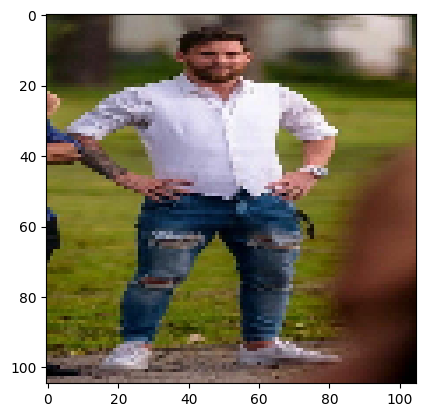

In [15]:
plt.imshow(res[0])


In [16]:
res[2]

1.0

In [17]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [18]:
samples = data.as_numpy_iterator()
samp = samples.next()

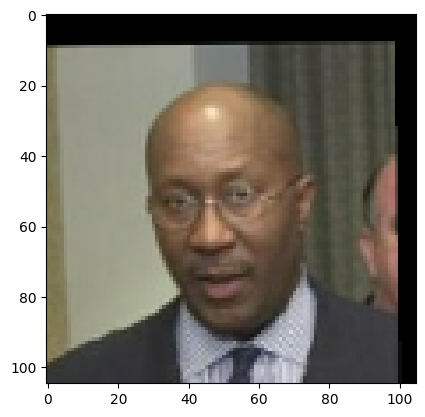

In [19]:
plt.imshow(samp[1])

In [20]:
samp[2]

0.0

In [21]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(8)
train_data = train_data.prefetch(8)

In [22]:
val_data = data.skip(round(len(data) * 0.7))
val_data = val_data.take(round(len(data) * 0.15))  
val_data = val_data.batch(8)
val_data = val_data.prefetch(8)

In [23]:
test_data = data.skip(round(len(data) * 0.85)) 
test_data = test_data.batch(8)
test_data = test_data.prefetch(8)

In [24]:
def make_embedding(): 
    inp = Input(shape=(105, 105, 3), name='input_image')
    
    # First block with L2 regularization
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D((2, 2), padding='same')(c1)
    
    # Second block with L2 regularization
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D((2, 2), padding='same')(c2)
    
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D((2, 2), padding='same')(c3)
    
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    
    d5 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d5], name='embedding')

In [25]:
embedding = make_embedding()
embedding.summary()


Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 105, 105, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [26]:
class L1Dist(Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
       
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [27]:
l1 = L1Dist()

In [28]:
input_image = Input(name='input_img', shape=(105,105,3))
validation_image = Input(name='validation_img', shape=(105,105,3))
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [29]:
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)


In [30]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(105,105,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(105,105,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [31]:
siamese_model = make_siamese_model()
siamese_model.summary()


Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

In [32]:
binary_cross_entropy = tf.losses.BinaryCrossentropy()


In [33]:
opt = tf.optimizers.Adam(1e-4)

In [34]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt , siamese_model = siamese_model)

In [35]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]

        yhat = siamese_model(X, training=True)
        loss = binary_cross_entropy(y, yhat)
        
    
    
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss


In [36]:
@tf.function
def val_step(batch):
    X = batch[:2]
    y = batch[2]
    
    yhat = siamese_model(X, training=False)
    loss = binary_cross_entropy(y, yhat)
    
    
    return loss


In [37]:
import matplotlib.pyplot as plt

def train(data, val_data, EPOCHS):
    # Initialize lists to store the training and validation losses
    train_losses = []
    val_losses = []

    for epoch in range(1, EPOCHS + 1):
        print(f'\nEpoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))
        
        epoch_loss = 0
        val_loss = 0

        # Training step
        for idx, batch in enumerate(data):
            batch_loss = train_step(batch)  # Call the train_step function
            epoch_loss += batch_loss
            progbar.update(idx + 1)

        # Calculate average training loss
        train_loss = epoch_loss / len(data)
        train_losses.append(train_loss)

        # Compute validation loss for the current epoch
        for val_batch in val_data:
            val_loss += val_step(val_batch)  # Call the val_step function

        val_loss /= len(val_data)
        val_losses.append(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Save checkpoint periodically
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

    # Plot training vs validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
    plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.show()



Epoch 1/50
26/26 [==============================] - 15s 108ms/step
Train Loss: 0.6885, Validation Loss: 0.6210

Epoch 2/50
26/26 [==============================] - 2s 58ms/step
Train Loss: 0.5397, Validation Loss: 0.3374

Epoch 3/50
26/26 [==============================] - 1s 57ms/step
Train Loss: 0.3868, Validation Loss: 0.3094

Epoch 4/50
26/26 [==============================] - 1s 57ms/step
Train Loss: 0.4803, Validation Loss: 0.2726

Epoch 5/50
26/26 [==============================] - 1s 56ms/step
Train Loss: 0.2523, Validation Loss: 0.1267

Epoch 6/50
26/26 [==============================] - 1s 58ms/step
Train Loss: 0.1303, Validation Loss: 0.1000

Epoch 7/50
26/26 [==============================] - 1s 56ms/step
Train Loss: 0.0618, Validation Loss: 0.1425

Epoch 8/50
26/26 [==============================] - 1s 56ms/step
Train Loss: 0.1010, Validation Loss: 0.0405

Epoch 9/50
26/26 [==============================] - 2s 58ms/step
Train Loss: 0.0245, Validation Loss: 0.0078

Epoch 1

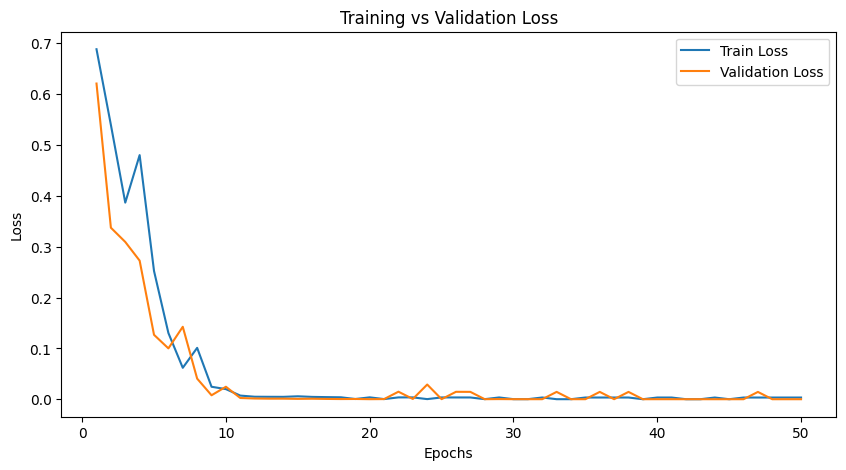

In [38]:
Epochs = 50

train(train_data,val_data,Epochs)

In [39]:
test_input , test_val , y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])
y_hat



array([[9.9998486e-01],
       [9.9979240e-01],
       [9.9998045e-01],
       [1.0000000e+00],
       [9.9995589e-01],
       [8.6198453e-09],
       [9.9999988e-01],
       [4.0812414e-05]], dtype=float32)

In [40]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]


[1, 1, 1, 1, 1, 0, 1, 0]

In [41]:
y_true


array([1., 1., 1., 1., 1., 0., 1., 0.], dtype=float32)

In [42]:
recall = Recall()
recall.update_state(y_true , y_hat)
print(f'Model Recall is: {recall.result().numpy()}')

Model Recall is: 1.0


In [43]:
precision = Precision()
precision.update_state(y_true , y_hat)
print(f'Model precision is: {precision.result().numpy()}')

Model precision is: 1.0


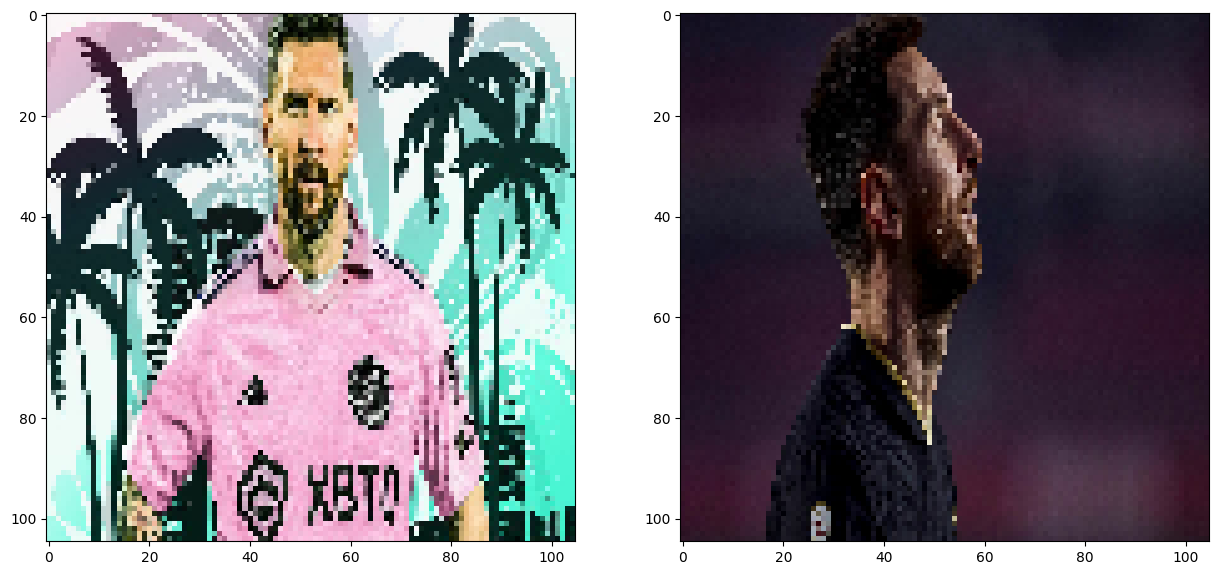

In [44]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.imshow(test_input[0])

plt.subplot(1,2,2)
plt.imshow(test_val[0])

plt.show()

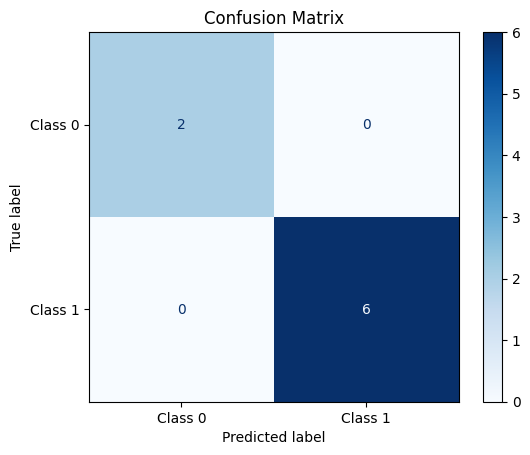

Accuracy: 1.0000


In [45]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay


y_hat = (y_hat > 0.5).astype(int) 

cm = confusion_matrix(y_true, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

accuracy = accuracy_score(y_true, y_hat)
print(f'Accuracy: {accuracy:.4f}')


In [46]:
siamese_model.save('siamesemodel.h5')
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})


In [47]:
model.predict([test_input, test_val])


array([[9.9998486e-01],
       [9.9979240e-01],
       [9.9998045e-01],
       [1.0000000e+00],
       [9.9995589e-01],
       [8.6198453e-09],
       [9.9999988e-01],
       [4.0812414e-05]], dtype=float32)

In [48]:
model.summary()


Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_3 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [49]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    verification_images_path = os.path.join("application_data", "verification_images")

    # Ensure input image and verification images exist
    input_image_path = os.path.join('application_data', 'input_image', 'input_image.jpg')
    if not os.path.exists(input_image_path):
        raise FileNotFoundError(f"Input image not found at {input_image_path}")

    num_images = len(os.listdir(verification_images_path))
    if num_images == 0:
        return [], False

    input_img = preprocess(input_image_path)

    for image in os.listdir(verification_images_path):
        validation_img = preprocess(os.path.join(verification_images_path, image))
        
        # Predict using two separate input tensors
        result = model.predict([
            np.expand_dims(input_img, axis=0),
            np.expand_dims(validation_img, axis=0)
        ])
        results.append(result)

    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / num_images if num_images > 0 else 0
    verified = verification > verification_threshold

    return results, verified


In [50]:
import os
import cv2

def capture_and_verify(model, detection_threshold=0.3, verification_threshold=0.5):
    cap = cv2.VideoCapture(1)
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Unable to read from camera.")
            break

        # Ensure safe slicing within frame bounds
        h, w, _ = frame.shape
        y_start, x_start = max(0, 120), max(0, 200)
        y_end, x_end = min(h, y_start + 250), min(w, x_start + 250)
        cropped_frame = frame[y_start:y_end, x_start:x_end]

        # Display cropped frame
        cv2.imshow('Verification', cropped_frame)

        key = cv2.waitKey(10) & 0xFF

        if key == ord('v'):  # Save frame and run verification
            input_img_path = os.path.join('application_data', 'input_image', 'input_image.jpg')
            os.makedirs(os.path.dirname(input_img_path), exist_ok=True)

            cv2.imwrite(input_img_path, cropped_frame)
            try:
                results, verified = verify(model, detection_threshold, verification_threshold)
                print("Verification Status:", verified)
            except Exception as e:
                print(f"Error during verification: {e}")

        elif key == ord('q'):  # Quit the program
            print("Exiting...")
            break

    cap.release()
    cv2.destroyAllWindows()


# Example function call with your model
# capture_and_verify(siamese_model)


In [51]:
capture_and_verify(siamese_model)

Verification Status: False
Verification Status: False
Verification Status: False
Verification Status: False
Verification Status: True
Verification Status: True
Verification Status: True
Verification Status: False
Verification Status: False
Verification Status: False
Verification Status: True
Verification Status: False
Verification Status: False
Verification Status: False
Verification Status: True
Verification Status: True
Verification Status: True
Verification Status: False
Verification Status: False
Exiting...
